In [99]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [100]:
df = pd.read_csv('HEROMOTOCO.csv')

In [101]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-07-31,1845.00,1849.949951,1807.599976,1819.400024,1425.192993,329505.0
1,2013-08-01,1820.00,1832.800049,1798.000000,1815.099976,1421.824707,373538.0
2,2013-08-02,1821.25,1850.000000,1780.050049,1801.800049,1411.406250,251833.0
3,2013-08-05,1803.75,1859.949951,1786.099976,1854.150024,1452.413818,1537397.0
4,2013-08-06,1851.00,1894.900024,1828.199951,1848.199951,1447.753052,370097.0


In [102]:
for i in range(len(df)):
  if numpy.isnan(df.at[i, 'Open']):
    df.drop(i, axis = 0, inplace = True)

In [103]:
df['OHLC'] = numpy.round(df[['Open', 'High', 'Low', 'Close']].mean(axis = 1), 2)

In [104]:
DF = df['OHLC']
DF.head()

0    1830.49
1    1816.48
2    1813.28
3    1825.99
4    1855.57
Name: OHLC, dtype: float64

In [105]:
scale = MinMaxScaler(feature_range=(0,1))
DF = scale.fit_transform(numpy.array(DF).reshape(-1,1))

In [106]:
valid_percent = 0.2
test_percent = 0.2
train_percent = 1 - (valid_percent + test_percent)

L = len(DF)

train_size = int(train_percent * L)
valid_size = int(valid_percent * L)
test_size = int(test_percent * L)

train_data = DF[0:train_size,:]
valid_data = DF[train_size:train_size + valid_size, :]
test_data = DF[train_size + valid_size:train_size + valid_size + test_size, :]

In [107]:
def create_inout_sequence(input_data, tw):
  input_seq = []
  input_label = []
  L = len(input_data)
  for i in range(L-tw):
    input_seq.append(input_data[i:i+tw,:])
    input_label.append(input_data[i+tw,:])
    
  return numpy.array(input_seq), numpy.array(input_label)

In [108]:
window = 15
X_train, y_train = create_inout_sequence(train_data, window)
X_valid, y_valid = create_inout_sequence(valid_data, window)
X_test, y_test = create_inout_sequence(test_data, window) 

In [113]:
model=Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True, dropout = 0.1), input_shape=(X_train.shape[1],1)))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False, dropout = 0.1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [114]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 15, 200)           81600     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 322,601
Trainable params: 322,601
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.fit(X_train, y_train, 32, 50, 1, validation_data=(X_valid, y_valid))

Epoch 1/50
32/32 [==============================] - 7s 225ms/step - loss: 0.0482 - val_loss: 0.0046
Epoch 2/50
32/32 [==============================] - 6s 201ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 3/50
32/32 [==============================] - 7s 212ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 4/50
32/32 [==============================] - 6s 199ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 5/50
32/32 [==============================] - 6s 198ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 6/50
32/32 [==============================] - 6s 200ms/step - loss: 0.0015 - val_loss: 0.0067
Epoch 7/50
32/32 [==============================] - 6s 199ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 8/50
32/32 [==============================] - 6s 197ms/step - loss: 0.0015 - val_loss: 0.0077
Epoch 9/50
32/32 [==============================] - 7s 205ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10/50
32/32 [==============================] - 7s 207ms/step - loss: 0.0013 - val_loss: 0.0048

In [116]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

In [117]:
train_predict = scale.inverse_transform(train_predict)
y_train = scale.inverse_transform(y_train)
valid_predict = scale.inverse_transform(valid_predict)
y_valid = scale.inverse_transform(y_valid)
test_predict = scale.inverse_transform(test_predict)
y_test = scale.inverse_transform(y_test)

In [118]:
math.sqrt(mean_squared_error(y_train,train_predict))

136.03695857201697

In [119]:
math.sqrt(mean_squared_error(y_valid,valid_predict))

166.36173289455294

In [120]:
math.sqrt(mean_squared_error(y_test,test_predict))

119.08314585798254

In [121]:
lookback = 15
trainpredict = numpy.empty_like(DF)
trainpredict[:,:] = numpy.nan
trainpredict[lookback:train_size, :] = train_predict

In [122]:
validpredict = numpy.empty_like(DF)
validpredict[:,:] = numpy.nan
validpredict[train_size + lookback:train_size + valid_size, :] = valid_predict

In [124]:
testpredict = numpy.empty_like(DF)
testpredict[:,:] = numpy.nan
testpredict[train_size + valid_size + lookback: -2, :] = test_predict

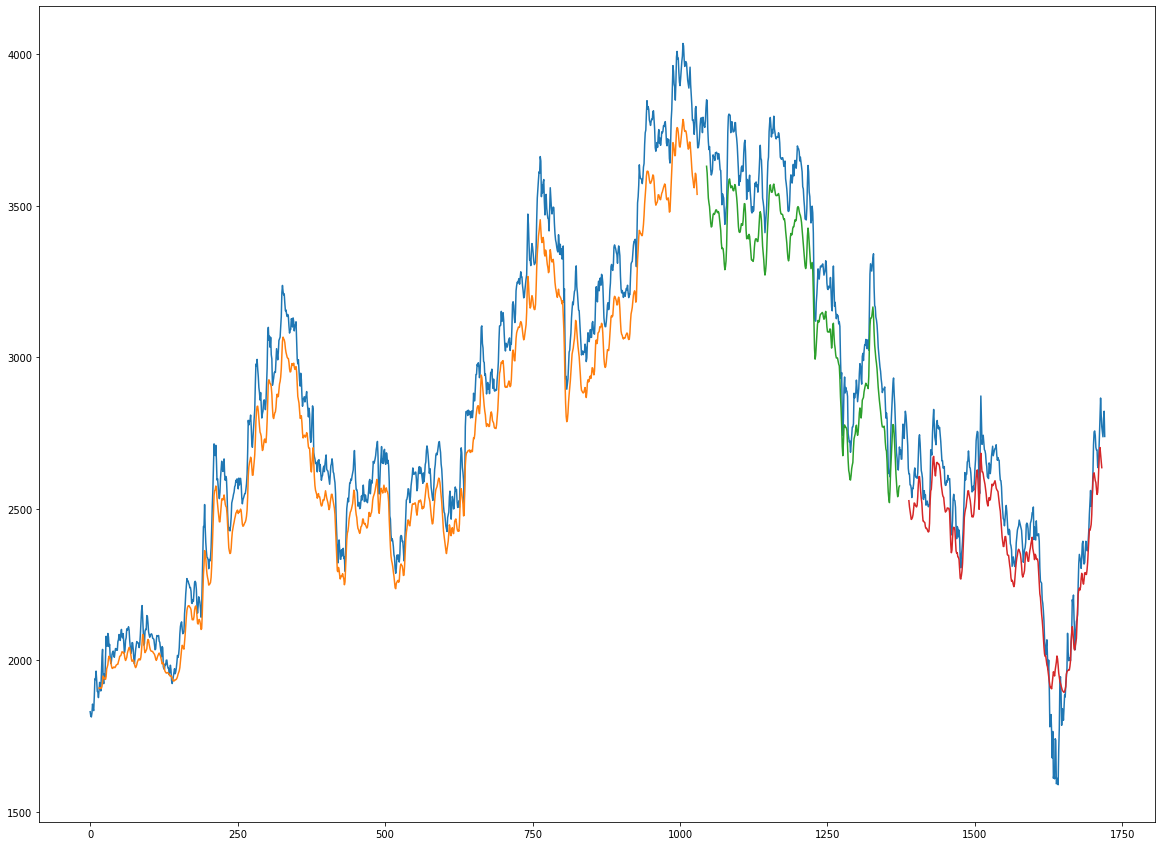

In [126]:
plt.figure(figsize=(20,15))
df['OHLC'].plot()

plt.plot(trainpredict)
plt.plot(validpredict)
plt.plot(testpredict)